<a href="https://colab.research.google.com/github/Mariammmmmmm/NLP/blob/main/Surnames_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Classifying Surnames with a Multilayer Perceptron

The code is greatly simplified and adapted from the book:

https://www.piter.com/collection/python/product/znakomstvo-s-pytorch-glubokoe-obuchenie-pri-obrabotke-estestvennogo-yazyka    

## Imports

In [ ]:
from collections import Counter
import json
import os
import string

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from tqdm.notebook import tqdm

In [ ]:
# to solve error "The kernel for *.ipynb appears to have died. It will restart automatically." 
# https://www.kaggle.com/product-feedback/41221
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# EDA

In [ ]:
df = pd.read_csv('surnames_with_splits.csv')
df.head()

,surname,nationality,split
0,Totah,Arabic,train
1,Abboud,Arabic,train
2,Fakhoury,Arabic,train
3,Srour,Arabic,train
4,Sayegh,Arabic,train


In [ ]:
df.shape

(10980, 3)

In [ ]:
df.split.value_counts()

train    7680
test     1660
val      1640
Name: split, dtype: int64

In [ ]:
df.nationality.value_counts()

English       2972
Russian       2373
Arabic        1603
Japanese       775
Italian        600
German         576
Czech          414
Spanish        258
Dutch          236
French         229
Chinese        220
Irish          183
Greek          156
Polish         120
Korean          77
Scottish        75
Vietnamese      58
Portuguese      55
Name: nationality, dtype: int64

In [ ]:
# df[df.nationality=='Vietnamese']

## Data Vectorization classes

### The Vocabulary

In [ ]:
nationalities = df.nationality.unique()
nation_idx = {n:i for i, n in enumerate(nationalities)}
idx_nation = {i:n for i, n in enumerate(nationalities)}

In [ ]:
nation_idx

{'Arabic': 0,
 'Chinese': 1,
 'Czech': 2,
 'Dutch': 3,
 'English': 4,
 'French': 5,
 'German': 6,
 'Greek': 7,
 'Irish': 8,
 'Italian': 9,
 'Japanese': 10,
 'Korean': 11,
 'Polish': 12,
 'Portuguese': 13,
 'Russian': 14,
 'Scottish': 15,
 'Spanish': 16,
 'Vietnamese': 17}

In [ ]:
letter = set("".join(df.surname))
letter_idx = {n:i for i, n in enumerate(letter)}

In [ ]:
# letter_idx

In [ ]:
len(letter_idx)

84

### The Vectorizer

In [ ]:
def vectorize(surname, letter_idx):
    """
    Args:
        surname (str): the surname

    Returns:
        one_hot (np.ndarray): a collapsed one-hot encoding 
    """
    one_hot = np.zeros(len(letter_idx), dtype=np.float32)
    for token in surname:
        one_hot[letter_idx[token]] = 1

    return one_hot

In [ ]:
vectorize('Afdgfghgjod', letter_idx)

array([1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

### The Dataset

In [ ]:
class SurnameDataset(Dataset):

    def __init__(self, surname_file):
        """
        Args:
            surname_df (pandas.DataFrame): the dataset
        """
        self.load_dataset(surname_file)

        self.train_df = self.surname_df[self.surname_df.split=='train']
        self.train_size = len(self.train_df)

        self.val_df = self.surname_df[self.surname_df.split=='val']
        self.validation_size = len(self.val_df)

        self.test_df = self.surname_df[self.surname_df.split=='test']
        self.test_size = len(self.test_df)

        self._lookup_dict = {'train': (self.train_df, self.train_size),
                             'val': (self.val_df, self.validation_size),
                             'test': (self.test_df, self.test_size)}

        self.set_split('train')


    def load_dataset(self, surname_csv):
        """Load dataset and make a new vectorizer from scratch
        
        Args:
            surname_csv (str): location of the dataset
        Returns:
            an instance of SurnameDataset
        """
        surname_df = pd.read_csv(surname_csv)
        
        nationalities = surname_df.nationality.unique()
        nation_idx = {n:i for i, n in enumerate(nationalities)}
        surname_df['y'] = surname_df['nationality'].map(nation_idx)
        
        self.surname_df = surname_df
        self.set_vocab(surname_df)
        
    def set_vocab(self, df):
        """Set vocab for surnames and nationalities"""
        letter = set("".join(df.surname))
        self.surname_vocab  = {n:i for i, n in enumerate(letter)}
        
        nationalities = df.nationality.unique()       
        
        self.nationality_vocab = {n:i for i, n in enumerate(nationalities)}
        self.inverse_nationality_vocab = {i:n for i, n in enumerate(nationalities)}
        
    def get_nationality(self, index):
        return self.inverse_nationality_vocab[index]

    def set_split(self, split="train"):
        """ selects the splits in the dataset using a column in the dataframe """
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]

    def __len__(self):
        return self._target_size

    def __getitem__(self, index):
        """the primary entry point method for PyTorch datasets
        
        Args:
            index (int): the index to the data point 
        Returns:
            a dictionary holding the data point's:
                features (x_surname)
                label (y_nationality)
        """
        row = self._target_df.iloc[index]

        surname_vector = vectorize(row.surname, self.surname_vocab)

        nationality_index = row.y

        return {'x_surname': surname_vector,
                'y_nationality': nationality_index}

    def get_num_batches(self, batch_size):
        """Given a batch size, return the number of batches in the dataset
        
        Args:
            batch_size (int)
        Returns:
            number of batches in the dataset
        """
        return len(self) // batch_size

    
def generate_batches(dataset, batch_size, shuffle=True,
                     drop_last=True, device="cpu"): 
    """
    A generator function which wraps the PyTorch DataLoader. It will 
      ensure each tensor is on the write device location.
    """
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)

    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict

In [ ]:
class SurnameVectorizer(object):
    """ The Vectorizer which coordinates the Vocabularies and puts them to use"""   
    def __init__(self, char_vocab, nationality_vocab):
        """
        Args:
            char_vocab (Vocabulary): maps characters to integers
            nationality_vocab (Vocabulary): maps nationalities to integers
        """
        self.char_vocab = char_vocab
        self.nationality_vocab = nationality_vocab

    def vectorize(self, surname, vector_length=-1):
        """
        Args:
            title (str): the string of characters
            vector_length (int): an argument for forcing the length of index vector
        """
        indices = [self.char_vocab.begin_seq_index]
        indices.extend(self.char_vocab.lookup_token(token) 
                       for token in surname)
        indices.append(self.char_vocab.end_seq_index)

        if vector_length < 0:
            vector_length = len(indices)

        out_vector = np.zeros(vector_length, dtype=np.int64)         
        out_vector[:len(indices)] = indices
        out_vector[len(indices):] = self.char_vocab.mask_index
        
        return out_vector, len(indices)


## The Model: SurnameClassifier

In [ ]:
class SurnameClassifierMLP(nn.Module):
    """ A 2-layer Multilayer Perceptron for classifying surnames """
    def __init__(self, input_dim, hidden_dim, output_dim):
        """
        Args:
            input_dim (int): the size of the input vectors
            hidden_dim (int): the output size of the first Linear layer
            output_dim (int): the output size of the second Linear layer
        """
        super(SurnameClassifierMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x_in, apply_softmax=False):
        """The forward pass of the classifier
        
        Args:
            x_in (torch.Tensor): an input data tensor. 
                x_in.shape should be (batch, input_dim)
            apply_softmax (bool): a flag for the softmax activation
                should be false if used with the Cross Entropy losses
        Returns:
            the resulting tensor. tensor.shape should be (batch, output_dim)
        """
        intermediate_vector = F.relu(self.fc1(x_in))
        prediction_vector = self.fc2(intermediate_vector)

        if apply_softmax:
            prediction_vector = F.softmax(prediction_vector, dim=1)

        return prediction_vector

## Training Routine

### Helper functions

In [ ]:
def make_train_state():
    return {'learning_rate': learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': -1,
            'test_acc': -1}


def compute_accuracy(y_pred, y_target):
    _, y_pred_indices = y_pred.max(dim=1)
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100

### Settings and some prep work

In [ ]:
num_epochs= 25
learning_rate=0.001
batch_size=64

cuda = False
if torch.cuda.is_available():
    cuda = True
device = torch.device("cuda" if cuda else "cpu")
    
print("device: {}".format(device))

device: cpu


### Initializations

In [ ]:
file_name = "surnames_with_splits.csv"
dataset = SurnameDataset(file_name)

In [ ]:
hidden_dim=30 # размер выходных результатов первого линейного слоя

In [ ]:
classifier = SurnameClassifierMLP(input_dim=len(dataset.surname_vocab), 
                               hidden_dim=hidden_dim, 
                               output_dim=len(dataset.nationality_vocab))

### Training loop

In [ ]:
classifier = classifier.to(device)
loss_func = nn.CrossEntropyLoss(weight=None)

optimizer = optim.Adam(classifier.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                 mode='min', factor=0.5,
                                                 patience=1)

train_state = make_train_state()

try:
    for epoch_index in tqdm(range(num_epochs)):
        train_state['epoch_index'] = epoch_index

        # Iterate over training dataset

        # setup: batch generator, set loss and acc to 0, set train mode on

        dataset.set_split('train')
        batch_generator = generate_batches(dataset, 
                                           batch_size=batch_size, 
                                           device=device)
        running_loss = 0.0
        running_acc = 0.0
        classifier.train()

        for batch_index, batch_dict in enumerate(batch_generator):
            # the training routine is these 5 steps:

            # --------------------------------------
            # step 1. zero the gradients
            optimizer.zero_grad()

            # step 2. compute the output
            y_pred = classifier(batch_dict['x_surname'])

            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_nationality'])
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # step 4. use loss to produce gradients
            loss.backward()

            # step 5. use optimizer to take gradient step
            optimizer.step()
            # -----------------------------------------
            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_nationality'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)


        train_state['train_loss'].append(running_loss)
        train_state['train_acc'].append(running_acc)

        # Iterate over val dataset

        # setup: batch generator, set loss and acc to 0; set eval mode on
        dataset.set_split('val')
        batch_generator = generate_batches(dataset, 
                                           batch_size=batch_size, 
                                           device=device)
        running_loss = 0.
        running_acc = 0.
        classifier.eval()

        for batch_index, batch_dict in enumerate(batch_generator):

            # compute the output
            y_pred =  classifier(batch_dict['x_surname'])

            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_nationality'])
            loss_t = loss.to("cpu").item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_nationality'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)

        train_state['val_loss'].append(running_loss)
        train_state['val_acc'].append(running_acc)

        scheduler.step(train_state['val_loss'][-1])

        
except KeyboardInterrupt:
    print("Exiting loop")

  0%|          | 0/25 [00:00<?, ?it/s]

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

In [ ]:
loss_labels = ["train_loss", "val_loss"]
acc_labels = ["train_acc", "val_acc"]

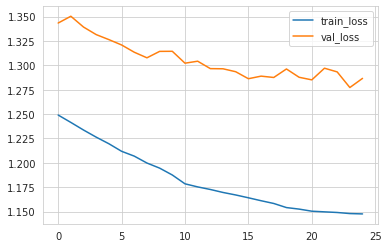

In [ ]:
for label in loss_labels:
    y = train_state[label]
    plt.plot(y, label=label)    
plt.legend()

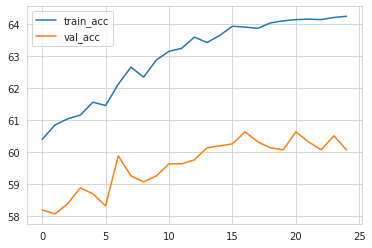

In [ ]:
for label in acc_labels:
    y = train_state[label]
    plt.plot(y, label=label)
plt.legend()

In [ ]:
dataset.set_split('test')
batch_generator = generate_batches(dataset, batch_size=batch_size, device=device)
running_loss = 0.
running_acc = 0.
classifier.eval()

for batch_index, batch_dict in enumerate(batch_generator):
  # вычисление выходных значений
  y_pred = classifier(batch_dict['x_surname'])
  # вычисление потерь
  loss = loss_func(y_pred, batch_dict['y_nationality'])
  loss_batch = loss.item()
  running_loss += (loss_batch - running_loss) / (batch_index + 1)
  # вычисление точности
  acc_batch = compute_accuracy(y_pred, batch_dict['y_nationality'])
  running_acc += (acc_batch - running_acc) / (batch_index + 1)

train_state['test_loss'] = running_loss
train_state['test_acc'] = running_acc

print("Test loss: {:.3f}".format(train_state['test_loss']))
print("Test Accuracy: {:.2f}".format(train_state['test_acc']))

Test loss: 1.281
Test Accuracy: 59.06


Изначально при использовании 30 нейронов в скрытом слое у нас accuracy - 55.94, затем мы изменили их количество на 50 и accuracy стало 59.56, теперь изменим на 120 и сейчас уже точность составляет 62, увеличим их количество до 300 точность - 65.69, теперь попробуем уменьшить количество до 10 точность снизилась до 54.94, и уменьшим количество до 3 точность уменьшилась до 49.38

Таким образом можно сделать вывод, что увеличение числа нейронов в скрытом слое может немного увеличить точность, а уменьшение уменьшить ее.

На данный момент используется оптимизатор Adam и точность составляет 56.75 , теперь изменим его на Adagrad получим точность 56.63, то есть в данном случает смена оптимизатора практически не повлияла на точность

На данный момент количество эпох составляет 25 и точность равна 57.94, посчитаем точность при 35 эпохах она равна - 59.94, при 45 эпохах точность 61.06, при 50 эпохах 61.44, теперь мы изменим количество эпох на 55 точность стала равна 58.50 (вероятно именно здесь и произожно переобучение).

На данной момент точность равна 56.75, а потери 1.354, теперь добавим в функцию потерь CrossEntropyLoss аргумент для учета весов классов теперь точность составляет 59.06, а потери 1.281.
Следовательно можно сделать вывод, что добавление аргумента для учета весов классов увеличивает точноть и уменьшает потери.

### Top-K Inference

In [ ]:
# в упрощенной версии обрабатываются только символы их словаря dataset.surname_vocab

In [ ]:
def predict_nationality(name, classifier, k=5):
    vectorized_name = vectorize(name, dataset.surname_vocab)
    vectorized_name = torch.tensor(vectorized_name).view(1, -1)
    prediction_vector = classifier(vectorized_name, apply_softmax=True)
    probability_values, indices = torch.topk(prediction_vector, k=k)
    
    # returned size is 1,k
    probability_values = probability_values.detach().numpy()[0]
    indices = indices.detach().numpy()[0]
    
    results = []
    for prob_value, index in zip(probability_values, indices):
        nationality = dataset.get_nationality(index)
        results.append({'nationality': nationality, 
                        'probability': prob_value})
    
    return results

In [ ]:
"""
classifier = classifier.to("cpu")
k=5    
predictions = predict_nationality(new_surname, classifier, k)

print("Top {} predictions:".format(k))
print("===================")
for prediction in predictions:
    print(" {} (p={:0.2f})".format(prediction['nationality'],
                                   prediction['probability']))
                                
"""

'\nclassifier = classifier.to("cpu")\nk=5    \npredictions = predict_nationality(new_surname, classifier, k)\n\nprint("Top {} predictions:".format(k))\nprint("===================")\nfor prediction in predictions:\n    print(" {} (p={:0.2f})".format(prediction[\'nationality\'],\n                                   prediction[\'probability\']))\n                                \n'

In [ ]:
"""
new_surname = input("Enter a surname to classify: ")
classifier = classifier.to("cpu")
k=5    
predictions = predict_nationality(new_surname, classifier, k)

print("Top {} predictions:".format(k))
print("===================")
for prediction in predictions:
    print(" {} (p={:0.2f})".format(prediction['nationality'],
                                   prediction['probability']))
    
"""

'\nnew_surname = input("Enter a surname to classify: ")\nclassifier = classifier.to("cpu")\nk=5    \npredictions = predict_nationality(new_surname, classifier, k)\n\nprint("Top {} predictions:".format(k))\nprint("===================")\nfor prediction in predictions:\n    print(" {} (p={:0.2f})".format(prediction[\'nationality\'],\n                                   prediction[\'probability\']))\n    \n'